# Data Importing

In [1]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Parameter Selection
PyFlux supports ARIMA, ARIMAX, and several other time-series models but no explicit implementation of SARIMA models. However, seasonal time-series can be modeled with ARIMA by providing *p*, *d*, or *q* parameters high enough to capture the seasonal correlations, although not adviced. Other approaches include pre-processing the data to have one model for the seasonal part and another for the non-seasonal part, pre-process the data by performaing the seasonal-order differencing then fit the differenced model, or pass seasonal variables as exogenous variables to the model.

For simplicity, adjust the *p* parameter to capture seasonal correlations in this excercise.

Another additional parameter in PyFlux is the user's prior knowledge or belief of the distribution for the time-series. This parameter is passed to the model as well. In this example, assume a normal distribution for the time-series

In conclusion, the parameters to pass to the ARIMA model:
* A lag of 24 for the AR parameter
* First-order differencing for I
* A lag of 3 for MA parameter
* Normal distribution for the prior probability function family parameter

# Model Fitting

In [2]:
import pyflux as pf
import time

model = pf.ARIMA(data=train_ts.values, ar=24, integ=1, ma=3, family=pf.Normal())
start = time.time()
model_fit = model.fit(dis=0)
print('fitting complete after {} seconds'.format(time.time()-start))

fitting complete after 40.03504490852356 seconds


In [3]:
model_fit.summary()

Normal ARIMA(24,1,3)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Series                  Method: MLE                                       
Start Date: 24                                          Log Likelihood: 3042.2644                         
End Date: 1058                                          AIC: -6026.5287                                   
Number of observations: 1034                            BIC: -5883.2342                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0001     0.0002     0.6578   0.5107   (-0.0002 | 0.0004)       
AR(1)                                

# Model Inference
The interesting feature about bayesian models is the ability to conduct baysian inference on the model paramters. This is done by inspecting the distribution of the paramters obtained as a result of the MCMC computation during model fitting

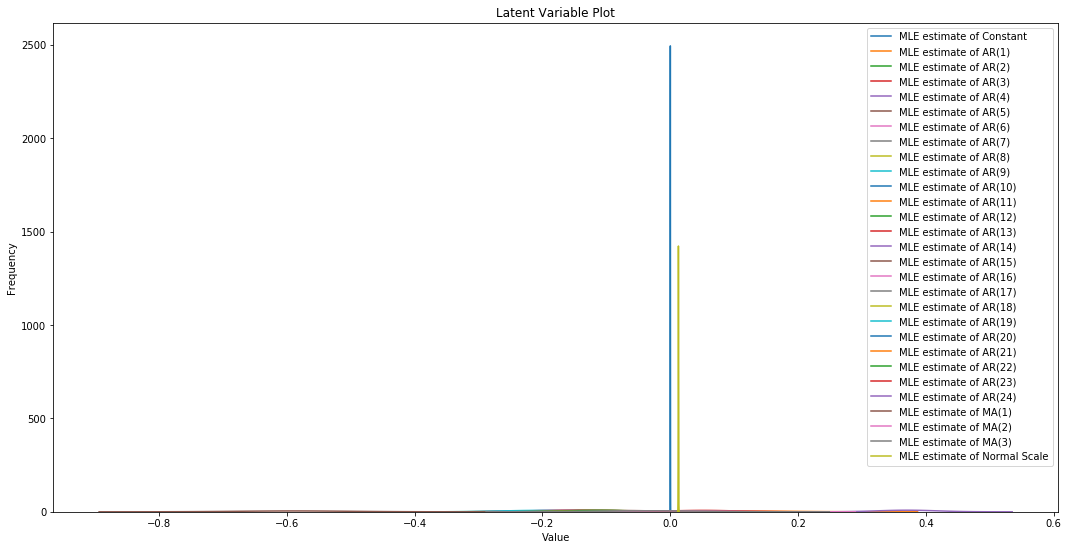

In [7]:
model.plot_z(figsize=(18,9))

The constant and the normal scale appear to be much more certain than all other parameters.

Inspect only all other parameters

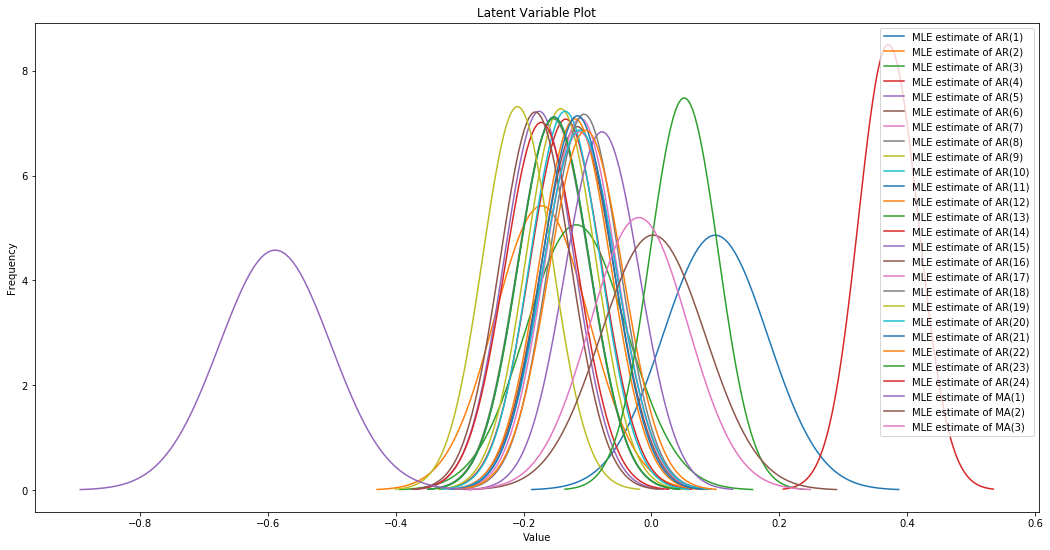

In [8]:
import numpy as np

model.plot_z(indices=list(np.arange(1,28)), figsize=(18,9))

AR24 appears to be the most certain, which is expected due to the 24-hours seasonal pattern 

# Forecasting
Generate forecast for the future and convert forecasts to pandas format for easier inspection and plotting.
Note that pyflux outputs the differenced forecasts, so these values need to be un-differenced

In [13]:
f_steps = val_ts.shape[0]
results = model.predict(h=f_steps, intervals=True)
results.iloc[0,:] = results.iloc[0,:] + train_ts[-1]
results = results.cumsum()

forecasts = results[['Differenced Series', '5% Prediction Interval', '95% Prediction Interval']]
forecasts.columns = ['Forecasts', 'Lower 95% CI', 'Upper 95% CI']
forecasts.index = val_ts.index

forecasts.head()

,Forecasts,Lower 95% CI,Upper 95% CI
timestamp,,,
2011-08-14 03:00:00,0.086222,0.065469,0.107259
2011-08-14 04:00:00,0.095961,0.054197,0.138427
2011-08-14 05:00:00,0.116644,0.053508,0.180857
2011-08-14 06:00:00,0.148020,0.063279,0.234038
2011-08-14 07:00:00,0.175416,0.068773,0.283470


Note that generating the prediction intervals requires consumes significant computational time in probablistic models.

# Validation
Compare forecasts against the hold-out validation set

Text(0.5, 1.0, 'MSE: 0.001047068920425383')

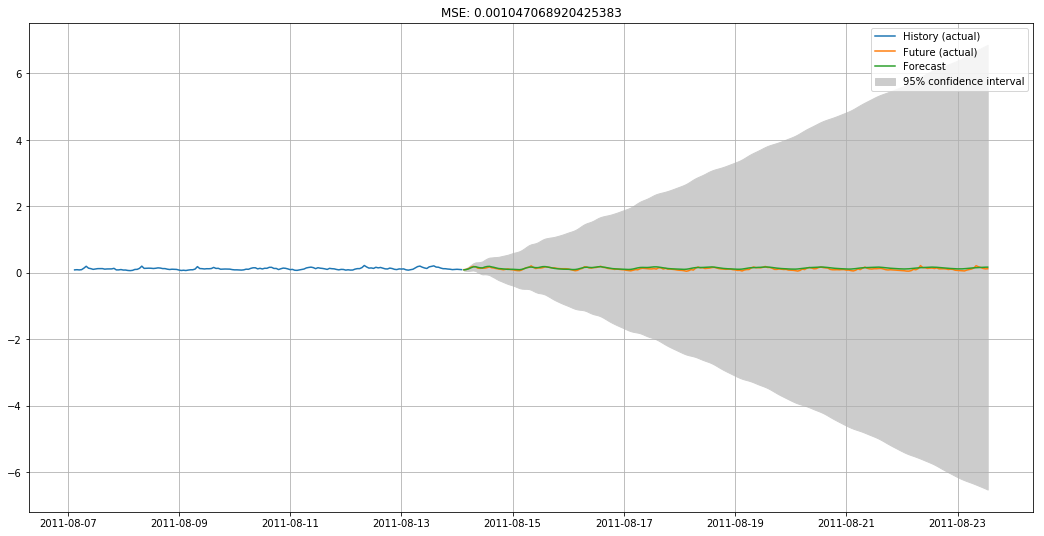

In [15]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['Forecasts'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['Forecasts'], label='Forecast')
plt.fill_between(forecasts.index, forecasts['Lower 95% CI'], forecasts['Upper 95% CI'], color='0.8',label='95% confidence interval')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

PLot again without the CI to adjust the scale:

Text(0.5, 1.0, 'MSE: 0.001047068920425383')

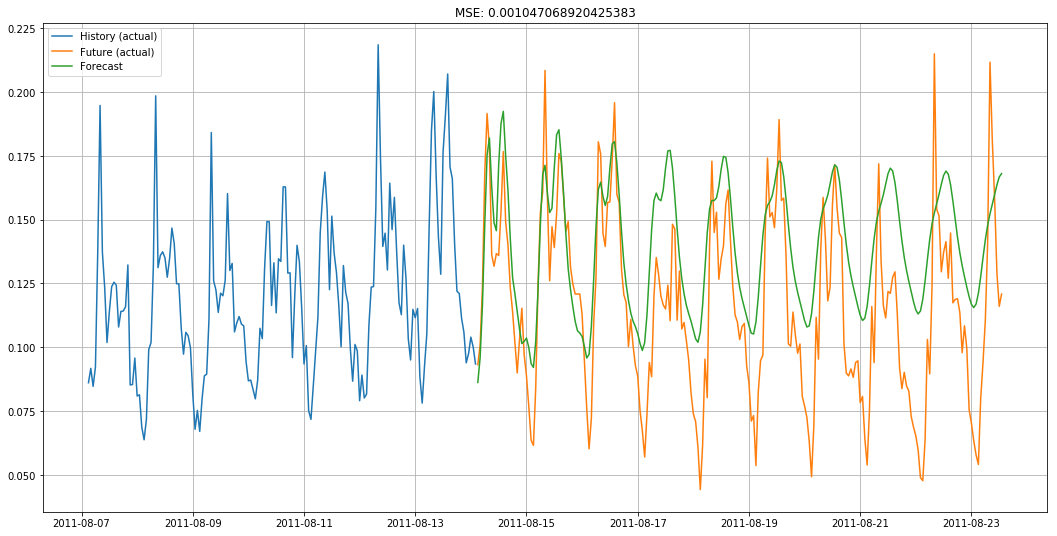

In [16]:
plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['Forecasts'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

We notice that the fit accuracy detoriorates faster compared to SARIMA model. This indicates that different model parameters, preprocessing requirements, and/or prior probability distribution assumptions are required